# Tensorpack tutorial 
#### In this tutorial, we are going to cover following steps.
* **Data Loading** (Dataflow)
* **Build a model**
* **Training & test** (CPU, GPU, or MultiGPU)
* **Trasfer learning** (Loading a saved Model and training it agiain)
* **Evaluation** (Loading a saved Model and test it)

#### You can find more specific explanations per function in [here](https://tensorpack.readthedocs.io/modules/index.html).

In [2]:
import cv2           # for AugmentImageComponent
import multiprocessing
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from tensorpack import *
from tensorpack.dataflow import *
from tensorpack.tfutils import summary

## 1. Get DataFlow
* You can **augment** your data in here.

In [3]:
def get_dataflow(batch_size, is_train='train'):
    df = dataset.Mnist(is_train, shuffle=True)

    # ----- Image Augmentation Options -------- #
    if is_train is 'train':
        augs = [
            #   imgaug.CenterCrop(256, 256),
            #   imgaug.Resize((225, 225)),
            #   imgaug.Grayscale(keepdims=True),
#                imgaug.Flip(horiz=True, vert=False, prob=0.5),
        ]
    else:
        augs = [
            #   imgaug.CenterCrop(256, 256),
            #   imgaug.Resize((225, 225)),
        ]
    df = AugmentImageComponent(df, augs)
    # group data into batches of size 128
    df = BatchData(df, batch_size)
    # start 3 processes to run the dataflow in parallel
    # df = PrefetchDataZMQ(df, 10, multiprocessing.cpu_count())
    return df

### See the data

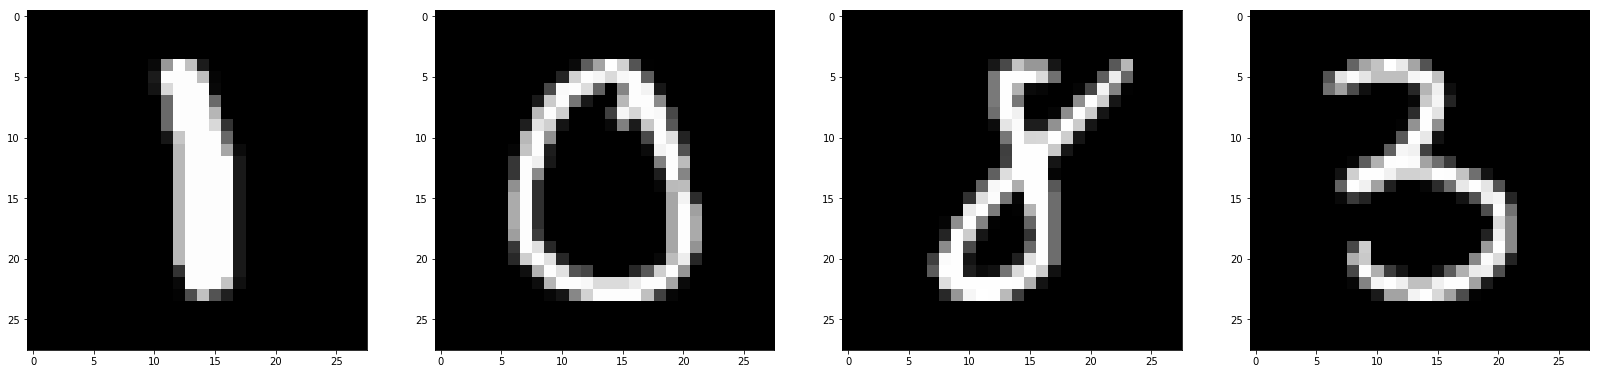

In [5]:
df = get_dataflow(4, 'train')
df.reset_state()

fig =plt.figure(figsize=(28, 28))

for idx, dp in enumerate(df.get_data()):
    if idx == 0:
        for i in range(4):
            img = dp[idx][i]
            fig.add_subplot(1, 4, i + 1)
            plt.imshow(img, cmap='gray')
        plt.show()
    break

## 2. Model 
#### Model includes Loss function & Optimizer

In [6]:
# Description of ModelDesc at
# https://tensorpack.readthedocs.io/modules/graph_builder.html#tensorpack.graph_builder.ModelDesc
class Model(ModelDesc):
    def inputs(self):
        """
        Define input shape
        """
        return [tf.placeholder(tf.float32, [None, 28, 28], 'input'),
                tf.placeholder(tf.int32, [None], 'label')]

    def build_graph(self, image, label):
        """
        Build the model which takes the input and return cost. 
        """
        # NHW to NHWC
        image = tf.expand_dims(image, 3)

        with argscope(Conv2D, filters=32, kernel_size=3, activation=tf.nn.relu):
            with tf.name_scope('layer1') as scope:
                layer1 = (LinearWrap(image)
                          .Conv2D('conv0')
                          .MaxPooling('pool0', 2)
                          .Dropout('dropout', rate=0.7)())

        with argscope(Conv2D, filters=64, kernel_size=3, activation=tf.nn.relu):
            with tf.name_scope('layer2') as scope:
                layer2 = (LinearWrap(layer1)
                          .Conv2D('conv1')
                          .MaxPooling('pool1', 2)
                          .Dropout('dropout', rate=0.7)())

        with argscope(Conv2D, filters=128, kernel_size=3, activation=tf.nn.relu):
            with tf.name_scope('layer3') as scope:
                layer3 = (LinearWrap(layer2)
                          .Conv2D('conv2')
                          .MaxPooling('pool2', 2)
                          .Dropout('dropout', rate=0.7)
                          .FullyConnected('fc1', units=10,
                                          activation=tf.identity)())
                
        # Cost function
        cost = tf.reduce_mean(
            tf.nn.sparse_softmax_cross_entropy_with_logits(logits=layer3, 
                                                           labels=label),
            name='Loss')
        
        correct = tf.cast(tf.equal(tf.argmax(layer3, -1, 
                                             output_type=tf.int32), 
                                   label),
                          tf.float32)
        accuracy = tf.reduce_mean(correct, name='accuracy')
        train_error = tf.reduce_mean(1 - correct, name='train_error')
        
        summary.add_moving_summary(train_error, accuracy)
        return cost

    def optimizer(self):
        lr = tf.train.exponential_decay(
            learning_rate=0.001,
            global_step=get_global_step_var(),
            decay_steps=468 * 10,
            decay_rate=0.3, staircase=True, name='learning_rate')
        # for tensorboard.
        tf.summary.scalar('lr', lr)
        return tf.train.AdamOptimizer(lr)

## 3. main.py
#### `logger` for tensorboard, `TrainConfig` for model configuration including model saver.
* If you use **auto_set_dir()**, it makes a **`'train_log'`** directory and makes another directory in it 
   with the same name of file.py. You can see the scalars with tensorboard at there.

### Tensorboard and datasets 

In [9]:
# for tensorboard 
logger.set_logger_dir('./mnist_result')
# logger.auto_set_dir()

[0814 17:37:53 @logger.py:109] WRN Log directory ./mnist_result exists! Use 'd' to delete it. 
[0814 17:37:53 @logger.py:112] WRN If you're resuming from a previous run, you can choose to keep it.
Press any other key to exit. 
Select Action: k (keep) / d (delete) / q (quit):k
[0814 17:37:57 @logger.py:67] Existing log file './mnist_result/log.log' backuped to './mnist_result/log.log.0814-173757'
[0814 17:37:57 @logger.py:74] Argv: /anaconda/lib/python3.6/site-packages/ipykernel_launcher.py -f /Users/chayesol/Library/Jupyter/runtime/kernel-e7081d95-93f3-403d-b842-642e49b327fb.json


In [7]:
# dataflow
df = get_dataflow(100, 'train')
df_test = get_dataflow(100, 'test')

df.reset_state()
df_test.reset_state()
steps_per_epoch = df.size()

### Training

In [6]:
"""
Configuration containing everything necessary in a training.
"""
config = TrainConfig(
    model = Model(),
    data = QueueInput(df),
    callbacks = [
        # save the model after every epoch
        ModelSaver(checkpoint_dir='./mnist_result'),
        InferenceRunner(
            df_test,
            ScalarStats(['Loss', 'accuracy'])),
#         ScheduledHyperParamSetter('learning_rate',
#                                   [(1, 0.1), 
#                                    (300, 0.01), 
#                                    (500, 0.001)])
    ],
    steps_per_epoch = steps_per_epoch,
    max_epoch = 10,
)

# training with CPU or GPU?
if tf.test.gpu_device_name():
    launch_train_with_config(config, SyncMultiGPUTrainer(4))
else:
    launch_train_with_config(config, SimpleTrainer())

[0814 17:06:21 @input_source.py:205] Setting up the queue 'QueueInput/input_queue' for CPU prefetching ...
[0814 17:06:21 @trainers.py:51] Building graph for a single training tower ...
[0814 17:06:21 @registry.py:121] conv0 input: [None, 28, 28, 1]
[0814 17:06:21 @registry.py:129] conv0 output: [None, 28, 28, 32]
[0814 17:06:21 @registry.py:121] pool0 input: [None, 28, 28, 32]
[0814 17:06:21 @registry.py:129] pool0 output: [None, 14, 14, 32]
[0814 17:06:21 @registry.py:121] conv1 input: [None, 14, 14, 32]
[0814 17:06:21 @registry.py:129] conv1 output: [None, 14, 14, 64]
[0814 17:06:21 @registry.py:121] pool1 input: [None, 14, 14, 64]
[0814 17:06:21 @registry.py:129] pool1 output: [None, 7, 7, 64]
[0814 17:06:21 @registry.py:121] conv2 input: [None, 7, 7, 64]
[0814 17:06:21 @registry.py:129] conv2 output: [None, 7, 7, 128]
[0814 17:06:21 @registry.py:121] pool2 input: [None, 7, 7, 128]
[0814 17:06:21 @registry.py:129] pool2 output: [None, 3, 3, 128]
[0814 17:06:21 @registry.py:121] fc1

100%|##########|600/600[01:14<00:00, 8.06it/s]

[0814 17:07:37 @base.py:260] Epoch 1 (global_step 600) finished, time:1 minute 14 seconds.
[0814 17:07:37 @saver.py:77] Model saved to ./mnist_result/model-600.



100%|##########|100/100[00:03<00:00,25.99it/s]

[0814 17:07:40 @monitor.py:435] QueueInput/queue_size: 50
[0814 17:07:40 @monitor.py:435] accuracy: 0.62432
[0814 17:07:40 @monitor.py:435] lr: 0.001
[0814 17:07:40 @monitor.py:435] train_error: 0.37568
[0814 17:07:40 @monitor.py:435] validation_Loss: 1.0275


[0814 17:07:40 @monitor.py:435] validation_accuracy: 0.8516
[0814 17:07:40 @group.py:48] Callbacks took 3.878 sec in total. InferenceRunner: 3.85 seconds
[0814 17:07:40 @base.py:250] Start Epoch 2 ...


100%|##########|600/600[01:10<00:00, 8.50it/s]

[0814 17:08:51 @base.py:260] Epoch 2 (global_step 1200) finished, time:1 minute 10 seconds.
[0814 17:08:51 @saver.py:77] Model saved to ./mnist_result/model-1200.



100%|##########|100/100[00:03<00:00,27.26it/s]

[0814 17:08:55 @monitor.py:435] QueueInput/queue_size: 50
[0814 17:08:55 @monitor.py:435] accuracy: 0.81819
[0814 17:08:55 @monitor.py:435] lr: 0.001
[0814 17:08:55 @monitor.py:435] train_error: 0.18181
[0814 17:08:55 @monitor.py:435] validation_Loss: 0.40052
[0814 17:08:55 @monitor.py:435] validation_accuracy: 0.9258
[0814 17:08:55 @group.py:48] Callbacks took 3.693 sec in total. InferenceRunner: 3.67 seconds
[0814 17:08:55 @base.py:250] Start Epoch 3 ...



100%|##########|600/600[01:07<00:00, 8.90it/s]

[0814 17:10:02 @base.py:260] Epoch 3 (global_step 1800) finished, time:1 minute 7 seconds.
[0814 17:10:02 @saver.py:77] Model saved to ./mnist_result/model-1800.



100%|##########|100/100[00:03<00:00,26.31it/s]

[0814 17:10:06 @monitor.py:435] QueueInput/queue_size: 50
[0814 17:10:06 @monitor.py:435] accuracy: 0.87529
[0814 17:10:06 @monitor.py:435] lr: 0.001
[0814 17:10:06 @monitor.py:435] train_error: 0.12471
[0814 17:10:06 @monitor.py:435] validation_Loss: 0.21716
[0814 17:10:06 @monitor.py:435] validation_accuracy: 0.956
[0814 17:10:06 @group.py:48] Callbacks took 3.823 sec in total. InferenceRunner: 3.8 seconds
[0814 17:10:06 @base.py:250] Start Epoch 4 ...



100%|##########|600/600[01:17<00:00, 7.69it/s]

[0814 17:11:24 @base.py:260] Epoch 4 (global_step 2400) finished, time:1 minute 17 seconds.
[0814 17:11:24 @saver.py:77] Model saved to ./mnist_result/model-2400.



100%|##########|100/100[00:03<00:00,25.25it/s]

[0814 17:11:28 @monitor.py:435] QueueInput/queue_size: 50
[0814 17:11:28 @monitor.py:435] accuracy: 0.89303
[0814 17:11:28 @monitor.py:435] lr: 0.001
[0814 17:11:28 @monitor.py:435] train_error: 0.10697
[0814 17:11:28 @monitor.py:435] validation_Loss: 0.15336
[0814 17:11:28 @monitor.py:435] validation_accuracy: 0.9672
[0814 17:11:28 @group.py:48] Callbacks took 4.013 sec in total. InferenceRunner: 3.96 seconds
[0814 17:11:28 @base.py:250] Start Epoch 5 ...



100%|##########|600/600[01:12<00:00, 7.92it/s]

[0814 17:12:41 @base.py:260] Epoch 5 (global_step 3000) finished, time:1 minute 12 seconds.
[0814 17:12:41 @saver.py:77] Model saved to ./mnist_result/model-3000.



100%|##########|100/100[00:04<00:00,23.46it/s]

[0814 17:12:45 @monitor.py:435] QueueInput/queue_size: 50
[0814 17:12:45 @monitor.py:435] accuracy: 0.91788
[0814 17:12:45 @monitor.py:435] lr: 0.001
[0814 17:12:45 @monitor.py:435] train_error: 0.082119
[0814 17:12:45 @monitor.py:435] validation_Loss: 0.12471
[0814 17:12:45 @monitor.py:435] validation_accuracy: 0.973
[0814 17:12:45 @group.py:48] Callbacks took 4.292 sec in total. InferenceRunner: 4.27 seconds
[0814 17:12:45 @base.py:250] Start Epoch 6 ...



100%|##########|600/600[01:15<00:00, 7.97it/s]

[0814 17:14:00 @base.py:260] Epoch 6 (global_step 3600) finished, time:1 minute 15 seconds.
[0814 17:14:00 @saver.py:77] Model saved to ./mnist_result/model-3600.



100%|##########|100/100[00:04<00:00,23.60it/s]

[0814 17:14:05 @monitor.py:435] QueueInput/queue_size: 50
[0814 17:14:05 @monitor.py:435] accuracy: 0.92214
[0814 17:14:05 @monitor.py:435] lr: 0.001
[0814 17:14:05 @monitor.py:435] train_error: 0.077856
[0814 17:14:05 @monitor.py:435] validation_Loss: 0.098244
[0814 17:14:05 @monitor.py:435] validation_accuracy: 0.9776
[0814 17:14:05 @group.py:48] Callbacks took 4.262 sec in total. InferenceRunner: 4.24 seconds
[0814 17:14:05 @base.py:250] Start Epoch 7 ...



100%|##########|600/600[01:12<00:00, 8.47it/s]

[0814 17:15:17 @base.py:260] Epoch 7 (global_step 4200) finished, time:1 minute 12 seconds.
[0814 17:15:17 @saver.py:77] Model saved to ./mnist_result/model-4200.



100%|##########|100/100[00:03<00:00,25.44it/s]

[0814 17:15:21 @monitor.py:435] QueueInput/queue_size: 50
[0814 17:15:21 @monitor.py:435] accuracy: 0.9213
[0814 17:15:21 @monitor.py:435] lr: 0.001
[0814 17:15:21 @monitor.py:435] train_error: 0.078695
[0814 17:15:21 @monitor.py:435] validation_Loss: 0.09223
[0814 17:15:21 @monitor.py:435] validation_accuracy: 0.9785
[0814 17:15:21 @group.py:48] Callbacks took 3.956 sec in total. InferenceRunner: 3.94 seconds
[0814 17:15:21 @base.py:250] Start Epoch 8 ...



100%|##########|600/600[01:20<00:00, 7.50it/s]

[0814 17:16:41 @base.py:260] Epoch 8 (global_step 4800) finished, time:1 minute 20 seconds.
[0814 17:16:41 @saver.py:77] Model saved to ./mnist_result/model-4800.



100%|##########|100/100[00:04<00:00,24.81it/s]

[0814 17:16:45 @monitor.py:435] QueueInput/queue_size: 50
[0814 17:16:45 @monitor.py:435] accuracy: 0.93926
[0814 17:16:45 @monitor.py:435] lr: 0.0003
[0814 17:16:45 @monitor.py:435] train_error: 0.060739
[0814 17:16:45 @monitor.py:435] validation_Loss: 0.071405
[0814 17:16:45 @monitor.py:435] validation_accuracy: 0.9831
[0814 17:16:45 @group.py:48] Callbacks took 4.053 sec in total. InferenceRunner: 4.03 seconds
[0814 17:16:45 @base.py:250] Start Epoch 9 ...



100%|##########|600/600[01:10<00:00, 7.70it/s]

[0814 17:17:56 @base.py:260] Epoch 9 (global_step 5400) finished, time:1 minute 10 seconds.
[0814 17:17:56 @saver.py:77] Model saved to ./mnist_result/model-5400.



100%|##########|100/100[00:04<00:00,24.19it/s]

[0814 17:18:00 @monitor.py:435] QueueInput/queue_size: 50
[0814 17:18:00 @monitor.py:435] accuracy: 0.93876
[0814 17:18:00 @monitor.py:435] lr: 0.0003
[0814 17:18:00 @monitor.py:435] train_error: 0.061243
[0814 17:18:00 @monitor.py:435] validation_Loss: 0.068353
[0814 17:18:00 @monitor.py:435] validation_accuracy: 0.9839
[0814 17:18:00 @group.py:48] Callbacks took 4.159 sec in total. InferenceRunner: 4.14 seconds
[0814 17:18:00 @base.py:250] Start Epoch 10 ...



100%|##########|600/600[01:07<00:00, 8.86it/s]

[0814 17:19:07 @base.py:260] Epoch 10 (global_step 6000) finished, time:1 minute 7 seconds.
[0814 17:19:07 @saver.py:77] Model saved to ./mnist_result/model-6000.



100%|##########|100/100[00:03<00:00,27.53it/s]

[0814 17:19:11 @monitor.py:435] QueueInput/queue_size: 50
[0814 17:19:11 @monitor.py:435] accuracy: 0.94222
[0814 17:19:11 @monitor.py:435] lr: 0.0003
[0814 17:19:11 @monitor.py:435] train_error: 0.057784
[0814 17:19:11 @monitor.py:435] validation_Loss: 0.063313
[0814 17:19:11 @monitor.py:435] validation_accuracy: 0.9847
[0814 17:19:11 @group.py:48] Callbacks took 3.655 sec in total. InferenceRunner: 3.64 seconds
[0814 17:19:11 @base.py:264] Training has finished!


[0814 17:19:11 @input_source.py:160] EnqueueThread QueueInput/input_queue Exited.


## 5. Loading The Saved Model 
#### Loading saved model and learning 5 epochs more.
##### In tensorflow, 
* **`.meta`** file means **the structure** of model, 
    all **variables, and operations.** 
* **`index`** means a binary file contating **weights, biases, and gradients**.

* We are going to use **`PredictConfig`** to evaluate the loaded and more trained model.

### Transfer Learning
* If you have any trouble with it, then consider **`logger.set_logger_dir(path_to_saved_model)`** carefully.

In [10]:
config = AutoResumeTrainConfig(
    model = Model(),
    session_init = get_model_loader('./mnist_result/model-6000.index'),
    data = QueueInput(df),
    callbacks = [
        # save the model after every epoch
        ModelSaver(checkpoint_dir='./transfer'),
        InferenceRunner(
            df_test,
            ScalarStats(['Loss', 'accuracy'])),
#         ScheduledHyperParamSetter('learning_rate',
#                                   [(1, 0.1), 
#                                    (300, 0.01), 
#                                    (500, 0.001)])
    ],
    steps_per_epoch = steps_per_epoch,
    max_epoch = 15,
)

launch_train_with_config(config, SimpleTrainer())

[0814 17:38:06 @varmanip.py:182] Checkpoint path ./mnist_result/model-6000.index is auto-corrected to ./mnist_result/model-6000.
[0814 17:38:06 @config.py:215] Found checkpoint at ./mnist_result/model-6000. session_init arguments will be overwritten.
[0814 17:38:06 @config.py:225] Found history statistics from JSON. Overwrite the starting epoch to epoch #11.
[0814 17:38:06 @input_source.py:205] Setting up the queue 'QueueInput/input_queue' for CPU prefetching ...
[0814 17:38:06 @trainers.py:51] Building graph for a single training tower ...
[0814 17:38:06 @registry.py:121] conv0 input: [None, 28, 28, 1]
[0814 17:38:06 @registry.py:129] conv0 output: [None, 28, 28, 32]
[0814 17:38:06 @registry.py:121] pool0 input: [None, 28, 28, 32]
[0814 17:38:06 @registry.py:129] pool0 output: [None, 14, 14, 32]
[0814 17:38:06 @registry.py:121] conv1 input: [None, 14, 14, 32]
[0814 17:38:06 @registry.py:129] conv1 output: [None, 14, 14, 64]
[0814 17:38:06 @registry.py:121] pool1 input: [None, 14, 14, 

100%|##########|600/600[01:26<00:00, 6.96it/s]

[0814 17:39:34 @base.py:260] Epoch 11 (global_step 6600) finished, time:1 minute 26 seconds.
[0814 17:39:34 @saver.py:77] Model saved to ./transfer/model-6600.



100%|##########|100/100[00:05<00:00,18.03it/s]

[0814 17:39:39 @monitor.py:435] QueueInput/queue_size: 50
[0814 17:39:39 @monitor.py:435] accuracy: 0.94823
[0814 17:39:39 @monitor.py:435] lr: 0.0003
[0814 17:39:39 @monitor.py:435] train_error: 0.051774
[0814 17:39:39 @monitor.py:435] validation_Loss: 0.061184
[0814 17:39:39 @monitor.py:435] validation_accuracy: 0.9856
[0814 17:39:39 @group.py:48] Callbacks took 5.574 sec in total. InferenceRunner: 5.55 seconds
[0814 17:39:39 @base.py:250] Start Epoch 12 ...



100%|##########|600/600[01:26<00:00, 7.30it/s]

[0814 17:41:05 @base.py:260] Epoch 12 (global_step 7200) finished, time:1 minute 26 seconds.
[0814 17:41:05 @saver.py:77] Model saved to ./transfer/model-7200.



100%|##########|100/100[00:05<00:00,17.84it/s]

[0814 17:41:11 @monitor.py:435] QueueInput/queue_size: 50
[0814 17:41:11 @monitor.py:435] accuracy: 0.94186
[0814 17:41:11 @monitor.py:435] lr: 0.0003
[0814 17:41:11 @monitor.py:435] train_error: 0.058136
[0814 17:41:11 @monitor.py:435] validation_Loss: 0.057191
[0814 17:41:11 @monitor.py:435] validation_accuracy: 0.9856
[0814 17:41:11 @group.py:48] Callbacks took 5.628 sec in total. InferenceRunner: 5.61 seconds
[0814 17:41:11 @base.py:250] Start Epoch 13 ...



100%|##########|600/600[01:26<00:00, 6.91it/s]

[0814 17:42:38 @base.py:260] Epoch 13 (global_step 7800) finished, time:1 minute 26 seconds.
[0814 17:42:38 @saver.py:77] Model saved to ./transfer/model-7800.



100%|##########|100/100[00:06<00:00,16.11it/s]

[0814 17:42:44 @monitor.py:435] QueueInput/queue_size: 50
[0814 17:42:44 @monitor.py:435] accuracy: 0.94769
[0814 17:42:44 @monitor.py:435] lr: 0.0003
[0814 17:42:44 @monitor.py:435] train_error: 0.052311
[0814 17:42:44 @monitor.py:435] validation_Loss: 0.056378
[0814 17:42:44 @monitor.py:435] validation_accuracy: 0.9857
[0814 17:42:44 @group.py:48] Callbacks took 6.237 sec in total. InferenceRunner: 6.21 seconds
[0814 17:42:44 @base.py:250] Start Epoch 14 ...



100%|##########|600/600[01:26<00:00, 7.16it/s]

[0814 17:44:10 @base.py:260] Epoch 14 (global_step 8400) finished, time:1 minute 26 seconds.
[0814 17:44:10 @saver.py:77] Model saved to ./transfer/model-8400.



100%|##########|100/100[00:05<00:00,18.68it/s]

[0814 17:44:16 @monitor.py:435] QueueInput/queue_size: 50
[0814 17:44:16 @monitor.py:435] accuracy: 0.94692
[0814 17:44:16 @monitor.py:435] lr: 0.0003
[0814 17:44:16 @monitor.py:435] train_error: 0.053084
[0814 17:44:16 @monitor.py:435] validation_Loss: 0.056021
[0814 17:44:16 @monitor.py:435] validation_accuracy: 0.9871
[0814 17:44:16 @group.py:48] Callbacks took 5.374 sec in total. InferenceRunner: 5.36 seconds
[0814 17:44:16 @base.py:250] Start Epoch 15 ...



100%|##########|600/600[01:24<00:00, 7.05it/s]

[0814 17:45:41 @base.py:260] Epoch 15 (global_step 9000) finished, time:1 minute 24 seconds.
[0814 17:45:41 @saver.py:77] Model saved to ./transfer/model-9000.



100%|##########|100/100[00:05<00:00,18.98it/s]

[0814 17:45:46 @monitor.py:435] QueueInput/queue_size: 50
[0814 17:45:46 @monitor.py:435] accuracy: 0.95449
[0814 17:45:46 @monitor.py:435] lr: 0.0003
[0814 17:45:46 @monitor.py:435] train_error: 0.045515
[0814 17:45:46 @monitor.py:435] validation_Loss: 0.052748
[0814 17:45:46 @monitor.py:435] validation_accuracy: 0.9865
[0814 17:45:46 @group.py:48] Callbacks took 5.291 sec in total. InferenceRunner: 5.27 seconds
[0814 17:45:46 @base.py:264] Training has finished!


[0814 17:45:46 @input_source.py:160] EnqueueThread QueueInput/input_queue Exited.


### Evaluation

In [9]:
model = Model()
session = get_model_loader('./mnist_result/model-6000.index')

pred_config = PredictConfig(
        model=model,
        session_init=session,
        input_names=['input', 'label'],
        output_names=['accuracy', 'Loss']
    )
pred = SimpleDatasetPredictor(pred_config, df_test)

[0814 15:31:02 @varmanip.py:182] Checkpoint path ./mnist_result/model-6000.index is auto-corrected to ./mnist_result/model-6000.
[0814 15:31:02 @sessinit.py:90] WRN The following variables are in the checkpoint, but not found in the graph: beta1_power:0, beta2_power:0, global_step:0
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
[0814 15:31:02 @sessinit.py:117] Restoring checkpoint from ./mnist_result/model-6000 ...
INFO:tensorflow:Restoring parameters from ./mnist_result/model-6000


In [26]:
accuracy = 0.0
total_loss = 0.0

for i, (acc, loss) in enumerate(pred.get_result()):
    accuracy += acc 
    total_loss += loss
    
print("Accuracy: {:0.3f}".format(accuracy/(i+1)))
print("Loss: {:0.3f}".format(total_loss/(i+1)))

100%|##########|100/100[00:04<00:00,20.11it/s]

Accuracy: 0.985
Loss: 0.067
